# 6 - Sísmica de reflexão: Correção de Normal Moveout (NMO) e empilhamento

Na aula passada, vimos que uma seção CMP é crucial para conseguirmos uma estimativa da velocidade. Nessa prática, veremos como utilizar a correção de NMO para fazer a **análise de velocidades**. Também veremos a técnica do empilhamento e como ela melhora a razão sinal-ruído do dado.


Utilizaremos as simulações de ondas da biblioteca [Fatiando a Terra](http://www.fatiando.org). Essas simulações utilizam o [método de diferenças finitas](http://en.wikipedia.org/wiki/Finite_difference_method) para calcular soluções da equação da onda.

## Objetivos

* Utilizar a correção de NMO para estimar velocidades.
* Ver como o empilhamento melhora a qualidade dos dados.

## Questão para entregar

<div class="alert alert-info" style="font-size:12pt; margin-top:20px">
<b>
Explique como é feita a análise de velocidades. As velocidades determinadas são as velocidades verdadeiras das camadas? Por que? Qual é vantagem de realizar o empilhamento? 
</b>
</div>

### Regras para a resposta

* Coloque **nome, data e o número da prática** em sua resposta. 
* A resposta pode ter no **máximo 1 página** (não uma folha).
* **Execute o notebook** antes de responder. As simulações abaixo foram feitas para te ajudar.
* **Pense e organize** sua resposta andtes de começar a escrever.

## Instruções

Esse documento é um [Jupyter notebook](http://jupyter.org/), um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

**Para executar uma célula**, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

## Setup

Rode as células abaixo para carregar os módulos necessários para essa prática.

In [1]:
%matplotlib inline
from __future__ import division, print_function
import math
from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipw
from fatiando.seismic import RickerWavelet, FDAcoustic2D
from fatiando import utils
from fatiando.vis import anim_to_html
from fatiando.vis.mpl import seismic_image, seismic_wiggle

/home/leo/miniconda3/envs/geofisica2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simulação de um CMP para um modelo de duas camadas

Rode as células abaixo para simular uma seção CMP para um modelo de duas camadas. A célula abaixo cria nosso modelo.

In [2]:
shape = (150, 200)
spacing = 10
extent = [0, shape[1]*spacing, shape[0]*spacing, 0]

# Velocidades
v1, v2 = 4000, 5000

densidade = np.ones(shape)*1600
velocidade = np.ones(shape)*v1
l1 = 40
densidade[l1:,:] = 1800
velocidade[l1:,:] = v2
l2 = 100
densidade[l2:,:] = 2000
velocidade[l2:,:] = 8000

Em seguida, precisamos definir onde serão localizadas as fontes e os receptores em nossa simulação. Vamos aproveitar e calcular também os espassamentos (offsets) dos receptores. Lembre-se: offset é a distância da conte ao receptor.

In [3]:
fontes = np.array(list(reversed(range(55, shape[1]//2 - 3, 3))))
recep = np.array([shape[1] - s for s in fontes])
offsets = (recep - fontes)*spacing
print("Utilizando {} fontes e {} receptores.".format(len(fontes), len(recep)))
print('Fontes:     {}'.format(fontes*spacing))
print('Receptores: {}'.format(recep*spacing))
print('Offsets:    {}'.format(offsets))

Utilizando 14 fontes e 14 receptores.
Fontes:     [940 910 880 850 820 790 760 730 700 670 640 610 580 550]
Receptores: [1060 1090 1120 1150 1180 1210 1240 1270 1300 1330 1360 1390 1420 1450]
Offsets:    [120 180 240 300 360 420 480 540 600 660 720 780 840 900]


Vamos rodar as simulações que precisamos (uma por fonte). **A barra de progresso não irá aparecer** pois vamos rodar as simulações em paralelo para agilizar o processo.

In [4]:
def simul_shot(fonte, its=1200, verbose=False):
    shot = FDAcoustic2D(velocidade, densidade, spacing=spacing, taper=0.005, padding=50, verbose=verbose)
    shot.add_point_source((0, fonte), RickerWavelet(1, 120))
    shot.run(its)
    return shot

In [5]:
%%time
print('Simulando...', end=' ')
pool = Pool(processes=cpu_count())
shots = pool.map(simul_shot, fontes)
pool.close()
print('Pronto.')

Simulando... Pronto.
CPU times: user 32.2 ms, sys: 34.3 ms, total: 66.5 ms
Wall time: 29.9 s


Vamos dar uma olhada na simulação de 1 tiro para ter uuma ideia do que acontece.

In [6]:
shots[0].animate(embed=True, dpi=60, fps=8, every=20, cutoff=0.5, cmap='Greys')

Vamos extrair os dados CMP da nossa simulação.

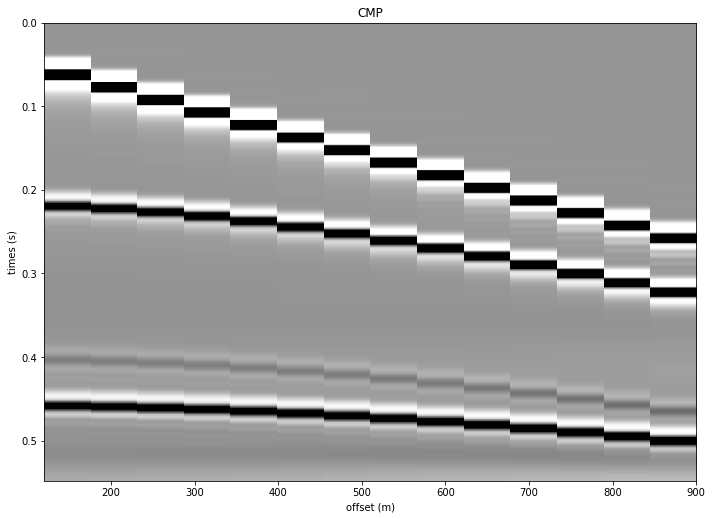

In [7]:
dt = shots[0].dt
times = np.linspace(0, dt*shots[0].simsize, shots[0].simsize)
CMP = np.empty((shots[0].simsize, len(recep)))
for i, s in enumerate(shots):
    CMP[:, i] = s[:, 0, recep[i]]
    
fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.set_title('CMP')
ax.set_xlabel('offset (m)')
ax.set_ylabel('times (s)')
cutoff = 0.1
ax.imshow(CMP, extent=[offsets.min(), offsets.max(), times.max(), times.min()], 
          aspect=1000, cmap='Greys', vmin=-cutoff, vmax=cutoff, interpolation='nearest')
fig.tight_layout()

### Para pensar

* Tente identificar a onda direta e as reflexões principais na simulação e no CMP.
* O que é o outro evento que aparece no CMP (acima da segunda reflexão)?

## Análise de velocidades

Agora que temos nosso CMP, podemos aplicar a correção de NMO e fazer a nossa análise de velocidades. Rode a célula abaixo para produzir uma figura interativa.

In [8]:
def nmo_correction(CMP, times, offsets, v):
    nmo = np.zeros_like(CMP)
    for i, t0 in enumerate(times):
        for j, o in enumerate(offsets):
            t = np.sqrt(t0**2 + o**2/v[i]**2)
            k = int(math.floor(t/dt))
            if k < times.size - 1:
                # Linear interpolation of the amplitude
                y0, y1 = CMP[k, j], CMP[k + 1, j]
                x0, x1 = times[k], times[k + 1]
                nmo[i, j] = y0 + (y1 - y0)*(t - x0)/(x1 - x0)
    return nmo

def analise_velocidades(CMP):
    def aplica_nmo(v1, v2):
        v = v1*np.ones_like(times)
        v[times > 0.35] = v2
        nmo = nmo_correction(CMP, times, offsets, v)

        fig = plt.figure(figsize=(12, 6))
        ax = plt.subplot(121)
        ax.set_title('CMP')
        ax.set_xlabel('offset (m)')
        ax.set_ylabel('times (s)')
        cutoff = 0.1
        ax.imshow(CMP, extent=[offsets.min(), offsets.max(), times.max(), times.min()], 
                  aspect=1000, cmap='Greys', vmin=-cutoff, vmax=cutoff, interpolation='nearest')    
        ax.grid()

        ax = plt.subplot(122)
        ax.set_title('Corrigido de NMO')
        ax.set_xlabel('offset (m)')
        ax.set_ylabel('times (s)')
        cutoff = 0.1
        ax.imshow(nmo, extent=[offsets.min(), offsets.max(), times.max(), times.min()], 
                  aspect=1000, cmap='Greys', vmin=-cutoff, vmax=cutoff, interpolation='nearest')    
        ax.grid()

        fig.tight_layout()
    widget = ipw.interactive(aplica_nmo, 
                             v1=ipw.FloatSlider(min=2000, max=6000, step=100, value=2000),
                             v2=ipw.FloatSlider(min=2000, max=6000, step=100, value=2000))
    return widget

analise_velocidades(CMP)

interactive(children=(FloatSlider(value=2000.0, description=u'v1', max=6000.0, min=2000.0, step=100.0), FloatSlider(value=2000.0, description=u'v2', max=6000.0, min=2000.0, step=100.0), Output()), _dom_classes=('widget-interact',))

### Figura acima

* O painel da esquerda mostra nosso CMP original.
* O painel da direita mostra o CMP após aplicação da correção NMO usando as velocidades especificadas.
* Você pode controlar as velocidades utilizadas na correção NMO do nosso CMP.

### Para pensar

* **Determine a velocidade das duas reflexões**.
* Essa velocidade é a velocidade real das camadas? Por que?

## Empilhamento

O CMP que simulamos acima não é muito realista pois não está contaminado com qualquer tipo de ruído. Então vamos sacanear o problema adicionando ruído aleatório nos nossos dados.

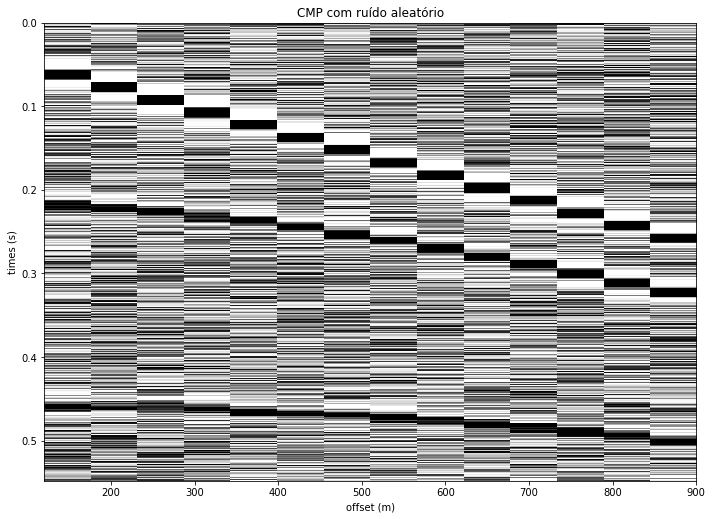

In [9]:
ruido = 0.1
CMP_ruido = CMP + np.random.uniform(-ruido, ruido, CMP.shape)
fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(111)
ax.set_title(u'CMP com ruído aleatório')
ax.set_xlabel('offset (m)')
ax.set_ylabel('times (s)')
cutoff = 0.1
ax.imshow(CMP_ruido, extent=[offsets.min(), offsets.max(), times.max(), times.min()], 
          aspect=1000, cmap='Greys', vmin=-cutoff, vmax=cutoff, interpolation='nearest')
fig.tight_layout()

Uma técnica que nos possibilita diminuir a influência do ruído aleatório é o **empilhamento**. A ideia é somar diversos dados que possuam um sinal coerente no meio de ruído aleatório.

Rode a célula abaixo para gerar uma figura interativa que ilustra esse conceito.

In [10]:
def empilhamento(ruido):
    N = 500
    M = 10
    if ruido <= 0:
        dados_ruido = np.array([np.zeros(N) for i in range(M)])
    else:
        dados_ruido = np.array([np.random.uniform(-ruido, ruido, size=N) for i in range(M)])
    x = np.arange(N)
    sinal = 1*utils.gaussian(x, 250, 2)
    dados = dados_ruido + sinal
    plt.figure(figsize=(10, 6))
    plt.subplot(121)
    plt.title(u'Dados com ruído e um sinal não-aleatório')
    for i, d in enumerate(dados):
        plt.plot(d + i + 1, x, '-k')
    plt.xlim(0, len(dados) + 1)
    plt.xlabel('# do dado')
    plt.grid()
    ax = plt.subplot(143)
    plt.title('Empilhamento')
    plt.plot(dados.sum(0), x, '-k')
    plt.grid()
    plt.xlim(-15, 15)
    plt.tight_layout()
ipw.interactive(empilhamento, ruido=ipw.FloatSlider(min=0, max=0.5, step=0.1, value=0))

interactive(children=(FloatSlider(value=0.0, description=u'ruido', max=0.5), Output()), _dom_classes=('widget-interact',))

### Figura acima

* O painel da esquerda mostra 10 conjuntos de dados com 1 sinal coerente no meio.
* O painel da direita mostra o resultado do empilhamento desses dados.
* Você pode controlar a quantidade de ruído aleatório que é inserido nos dados da esquerda.

### Para pensar

* Com o máximo de ruído você consegue enxergar o sinal nos dados originais? E no empilhamento?

### Empilhamento após análise de velocidades

Para poder fazer o empilhamento, precisamos ter um sinal coerente entre todos os traços. Isso significa que a nossa reflexão precisa acontecer no mesmo tempo em todos os traços. Felizmente, é exatamente isso que obtemos após a análise de velocidades e correção NMO.

Rode a célula abaixo para gerar a figura interativa da análise de velocidades. Dessa vez vamos motrar também o resultado do empilhamento da seção corrigida de NMO.

In [11]:
def nmo_empilhamento(v1, v2):
    v = v1*np.ones_like(times)
    v[times > 0.35] = v2
    nmo = nmo_correction(CMP_ruido, times, offsets, v)
    stack = np.atleast_2d(nmo.sum(1)).T
        
    fig = plt.figure(figsize=(12, 6))
    ax = plt.subplot(131)
    ax.set_title('CMP')
    ax.set_xlabel('offset (m)')
    ax.set_ylabel('times (s)')
    cutoff = 0.1
    ax.imshow(CMP_ruido, extent=[offsets.min(), offsets.max(), times.max(), times.min()], 
              aspect=2500, cmap='Greys', vmin=-cutoff, vmax=cutoff, interpolation='nearest')    
    ax.grid()
    
    ax = plt.subplot(132)
    ax.set_title('Corrigido de NMO')
    cutoff = 0.1
    ax.imshow(nmo, extent=[offsets.min(), offsets.max(), times.max(), times.min()], 
              aspect=2500, cmap='Greys', vmin=-cutoff, vmax=cutoff, interpolation='nearest')    
    ax.grid()
    
    ax = plt.subplot(165)
    ax.set_title(u'Primeiro traço do NMO')
    seismic_wiggle(np.atleast_2d(nmo[:, 0]).T, dt=dt, scale=1)
    ax.set_xlim(-1, 1)
    ax.grid()
    
    ax = plt.subplot(166)
    ax.set_title('Empilhamento')
    seismic_wiggle(stack, dt=dt, scale=1)
    ax.set_xlim(-10, 10)
    ax.grid()
    
    fig.tight_layout(pad=0, w_pad=0)

ipw.interactive(nmo_empilhamento, 
                v1=ipw.FloatSlider(min=2000, max=6000, step=100, value=2000),
                v2=ipw.FloatSlider(min=2000, max=6000, step=100, value=2000))

interactive(children=(FloatSlider(value=2000.0, description=u'v1', max=6000.0, min=2000.0, step=100.0), FloatSlider(value=2000.0, description=u'v2', max=6000.0, min=2000.0, step=100.0), Output()), _dom_classes=('widget-interact',))

### Figura acima

* O painel 1 mostra o CMP contaminado com ruído aleatório.
* O painel 2 mostra o resultado da correção de NMO.
* O painel 3 mostra o primeiro traço da seção corrigida de NMO (sem empilhamento).
* O painel 4 mostra o resultado do empilhamento da seção corrigida de NMO.

### Para pensar

* Como o resultado do empilhamento muda quando você utiliza as velocidades correta para NMO?
* Como o traço empilhado se compara a um traço normal do NMO (sem empilhamento)?

## License and information

**Course website**: https://github.com/leouieda/geofisica2

**Note**: This notebook is part of the course "Geofísica 2" of Geology program of the 
[Universidade do Estado do Rio de Janeiro](http://www.uerj.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)